## Generating Synthetic Questions and Answers for RAG Evaluation

This notebook demonstrates how to use Cortex to generate synthetic questions and answers for evaluating a RAG application

This is a following the example in the [Hugging Face RAG evaluation notebook](https://huggingface.co/learn/cookbook/rag_evaluation), but using Cortex to generate the synthetic questions and answers and performing the operations in Snowpark (and not on the local machine).

In [1]:
# Snowpark for Python
from snowflake.snowpark.session import Session
from snowflake.snowpark.types import Variant
from snowflake.snowpark.version import VERSION

# Snowpark ML
# Misc
import pandas as pd
import json
import logging 
logger = logging.getLogger("snowflake.snowpark.session")
logger.setLevel(logging.ERROR)

from snowflake import connector
from snowflake.ml.utils import connection_params

In [2]:
with open('../../creds.json') as f:
    data = json.load(f)
    USERNAME = data['user']
    PASSWORD = data['password']
    SF_ACCOUNT = data['account']
    SF_WH = data['warehouse']

CONNECTION_PARAMETERS = {
   "account": SF_ACCOUNT,
   "user": USERNAME,
   "password": PASSWORD,
}

session = Session.builder.configs(CONNECTION_PARAMETERS).create()

In [3]:
snowflake_environment = session.sql('select current_user(), current_version()').collect()
snowpark_version = VERSION

from snowflake.ml import version
mlversion = version.VERSION


# Current Environment Details
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))
print('Snowflake ML version        : {}.{}.{}'.format(mlversion[0],mlversion[2],mlversion[4]))

User                        : RSHAH
Role                        : "RAJIV"
Database                    : "RAJIV"
Schema                      : "DOCAI"
Warehouse                   : "RAJIV"
Snowflake version           : 8.18.0
Snowpark for Python version : 1.11.1
Snowflake ML version        : 1.5.0


## Get Data
I start with the SEC RAG example where the data has already been chunked. 

In [4]:
from snowflake.snowpark.functions import col
import snowflake.snowpark.functions as f
from snowflake.snowpark.functions import col, split, lit, regexp_extract
from snowflake.cortex import Complete


article_df = session.table("RAJIV.PUBLIC.CONTENT_CHUNKS_10K")
filtered_df = article_df.filter(col("company_name").like("RIVIAN%"))

# Now you can perform further operations on filtered_df, like displaying the data
filtered_df.show()


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SEC_DOCUMENT_ID"          |"DOCUMENT_TYPE"   |"COMPANY_NAME"                |"SIC_CODE_CATEGORY"      |"SIC_CODE_DESCRIPTION"                 |"COUNTRY"  |"PERIOD_END_DATE"  |"CONTENT_CHUNK"                                     |"START_INDEX"  |"EMBEDDING"                                         |"DOCUMENT_INDEX_ROWNUM"  |"ROWNUM"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [5]:
filtered_df.count()

497

You will only want to select a subset of the chunks to build your generated examples. 

In [6]:
shuffled_df = filtered_df.sample(n=30)
shuffled_df.count()

30

Let's build the Q&A pairs for the RAG evaluation.

In [7]:
QA_generation_prompt = """
Your task is to write a factoid question and an answer given a context.
Your factoid question should be answerable with a specific, concise piece of factual information from the context.
Your factoid question should be formulated in the same style as questions users could ask in a search engine.
This means that your factoid question MUST NOT mention something like "according to the passage" or "context".

Provide your answer as follows:

Output:::
Factoid question: (your factoid question)
Answer: (your answer to the factoid question)

Now here is the context.

Context: """

In [8]:
outdf = shuffled_df.withColumn(
    "GenQA",
    Complete(
        model='mixtral-8x7b',prompt = f.concat(
            f.lit(QA_generation_prompt),
            f.col("CONTENT_CHUNK"),
            f.lit("\n Output:::")
            ))
)
outputs = outdf.to_pandas()

Complete() is experimental since 1.0.12. Do not use it in production. 


In [9]:
outputs.GENQA[1]

' Factoid question: How is the market for new alternative energy vehicles described?\nAnswer: The market for new alternative energy vehicles is rapidly evolving, with changing technologies, competitive pricing and factors, evolving government regulation and industry standards, and changing consumer demands and behaviors.'

In [10]:
outdf = outdf.withColumn("split_col", split(col("GENQA"), lit('\n')))

# Create new columns 'GENQ' and 'GENA' by accessing elements of the array
outdf = outdf.withColumn("GENQ", col("split_col")[0])
outdf = outdf.withColumn("GENA", col("split_col")[1])

outdf.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SEC_DOCUMENT_ID"          |"DOCUMENT_TYPE"   |"COMPANY_NAME"                |"SIC_CODE_CATEGORY"      |"SIC_CODE_DESCRIPTION"                 |"COUNTRY"  |"PERIOD_END_DATE"  |"CONTENT_CHUNK"                                     |"START_INDEX"  |"EMBEDDING"                                         |"DOCUMENT_INDEX_ROWNUM"  |"ROWNUM"  |"GENQA"                                             |"SPLIT_COL"                                         |"GENQ"   

In [11]:
#save our work periodically
table_name = "RAJIV.PUBLIC.CONTENT_CHUNKS_10K_GQA"  # Specify your new table name here
outdf.write.mode("overwrite").save_as_table(table_name)

In [12]:
outdf = session.table("RAJIV.PUBLIC.CONTENT_CHUNKS_10K_GQA")

## Critique

The questions generated by the previous agent can have many flaws: we should do a quality check before validating these questions.

### Groundness Criteria

In [13]:
question_groundedness_critique_prompt = """
You will be given a context and a question.
Your task is to provide a 'total rating' scoring how well one can answer the given question unambiguously with the given context.
Give your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a integer between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here are the question and context.

Question: """

In [14]:
outdf = outdf.withColumn(
    "Eval_Groundness",
    Complete(
        model='mixtral-8x7b',prompt = f.concat(
            f.lit(question_groundedness_critique_prompt),
            f.col("GENQ"),
            f.lit("\n Context: "),
            f.col("CONTENT_CHUNK"),
            f.lit("\n Answer:::")
            ))
)

In [15]:
## you can always pull this into pandas to see the results
outputs = outdf.to_pandas()
outputs.EVAL_GROUNDNESS[4]

" Evaluation: The context explains the reasons for the unreliability of the automated and manual process level controls over financial reporting at the Company. The Company's risk assessment process was not effective, leading to ineffective ITGCs, and the Company did not establish effective user access and segregation of duties controls across financially relevant functions. These issues caused the automated and manual process level controls to be unreliable.\n\nTotal rating: 5\n\nThe context provides a clear and unambiguous answer to the question. The reasons for the unreliability of the controls are explicitly stated, making it easy to understand why the automated and manual process level controls were unreliable."

Let's split out the score,which will later filter on.

In [16]:
# Extracting the score by taking the rightmost character of the last part of split_rating
outdf = outdf.withColumn("score_EG", regexp_extract(col("EVAL_GROUNDNESS"), r"Total rating:\s*(\d)", 1))

outdf.write.saveAsTable("RAJIV.PUBLIC.CONTENT_CHUNKS_10K_GQA_All", mode="overwrite")
# Show results to verify
outdf.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SEC_DOCUMENT_ID"          |"DOCUMENT_TYPE"   |"COMPANY_NAME"                |"SIC_CODE_CATEGORY"      |"SIC_CODE_DESCRIPTION"                 |"COUNTRY"  |"PERIOD_END_DATE"  |"CONTENT_CHUNK"                                     |"START_INDEX"  |"EMBEDDING"                                         |"DOCUMENT_INDEX_ROWNUM"  |"ROWNUM"  |"GENQA"                                          

### Relevance Criteria

In [17]:
question_relevance_critique_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how useful this question can be to analysts.
Give your answer on a scale of 1 to 5, where 1 means that the question is not useful at all, and 5 means that the question is extremely useful.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as an integer between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the question.

Question: """

In [18]:
outdf = outdf.withColumn(
    "EVAL_RELEVANCE",
    Complete(
        model='mixtral-8x7b',prompt = f.concat(
            f.lit(question_relevance_critique_prompt),
            f.col("GENQ"),
            f.lit("\n Answer:::")
            ))
)

# Extracting the score by taking the rightmost character of the last part of split_rating
outdf = outdf.withColumn("score_ER", regexp_extract(col("EVAL_RELEVANCE"), r"Total rating:\s*(\d)", 1))

outdf.write.saveAsTable("RAJIV.PUBLIC.CONTENT_CHUNKS_10K_GQA_All", mode="overwrite")
# Show results to verify
outdf.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SEC_DOCUMENT_ID"          |"DOCUMENT_TYPE"   |"COMPANY_NAME"                |"SIC_CODE_CATEGORY"      |"SIC_CODE_DESCRIPTION"                 |"COUNTRY"  |"PERIOD_END_DATE"  |"CONTENT_CHUNK"                                     |"START_INDEX"  |"EMBEDDING"                                         |"DOCUMENT_INDEX_ROWN

### Critique Criteria

In [19]:
question_standalone_critique_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how context-independant this question is.
Give your answer on a scale of 1 to 5, where 1 means that the question depends on additional information to be understood, and 5 means that the question makes sense by itself.
For instance, if the question refers to a particular setting, like 'in the context' or 'in the document', the rating must be 1.
The questions can contain obscure technical nouns or acronyms like Gradio, Hub, Hugging Face or Space and still be a 5: it must simply be clear to an operator with access to documentation what the question is about.

For instance, "What is the name of the checkpoint from which the ViT model is imported?" should receive a 1, since there is an implicit mention of a context, thus the question is not independant from the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as an integer between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the question.

Question: """

In [20]:
outdf = outdf.withColumn(
    "EVAL_CRITIQUE",
    Complete(
        model='mixtral-8x7b',prompt = f.concat(
            f.lit(question_relevance_critique_prompt),
            f.col("GENQ"),
            f.lit("\n Answer:::")
            ))
)

# Extracting the score by taking the rightmost character of the last part of split_rating
outdf = outdf.withColumn("score_EC", regexp_extract(col("EVAL_CRITIQUE"), r"Total rating:\s*(\d)", 1))
outdf.write.saveAsTable("RAJIV.PUBLIC.CONTENT_CHUNKS_10K_GQA_All", mode="overwrite")

# Show results to verify
outdf.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SEC_DOCUMENT_ID"          |"DOCUMENT_TYPE"   |"COMPANY_NAME"                |"SIC_CODE_CATEGORY"      |"SIC_CODE_DESCRIPTION"                 |"COUNTRY"  |"PERIOD_END_DATE"  |"CONTENT_CHUNK"                                     |"START_INDEX"  |"EMBEDD

Let's keep only the questions that have scored well, by filtering on the score.

In [21]:
filtered_df = outdf.filter((outdf['SCORE_EC'] > 3) & (outdf['SCORE_ER'] > 3) & (outdf['SCORE_EG'] > 3))
filtered_df.count()


16

In [22]:
selected_df = filtered_df.select("CONTENT_CHUNK", "GENQ", "GENA")
# Now, to save this DataFrame as a new table in Snowflake
selected_df.write.mode("overwrite").saveAsTable("RAJIV.PUBLIC.CONTENT_CHUNKS_10K_GQA")

### Let's Get Predictions on our Generated Questions

In [23]:
from snowflake.snowpark.functions import col
import snowflake.snowpark.functions as f
from snowflake.snowpark.functions import col, split, lit, regexp_extract
from snowflake.cortex import Complete

Let's get predictions for the snythetic questions we have already created.

In [24]:
gen_qa = session.table("RAJIV.PUBLIC.CONTENT_CHUNKS_10K_GQA")
df_gen_qa = gen_qa.toPandas()
df_gen_qa.head()

,CONTENT_CHUNK,GENQ,GENA
0,". Also, customers may customize their vehicles...",""" Factoid question: What can compromise the ve...","""Answer: Modifying a vehicle's charging system..."
1,". Even if this is not the case, our current ac...",""" Factoid question: What changes may companies...","""Answer: The SEC has proposed rules that requi..."
2,". Based on this assessment, management conclud...",""" Factoid question: Why were the automated and...","""Answer: The automated and manual process leve..."
3,. Failure to comply with these laws and regula...,""" Factoid question: What are the potential con...","""Answer: Failure to comply with these laws and..."
4,. Customer behavior and usage may result in hi...,""" Factoid question: What factors could adverse...","""Answer: Customer behavior and usage, unsucces..."


In [25]:
def get_response(session, question):
    # Prepare the SQL command
    sql_command = f"""
    WITH question AS (
        SELECT '{question.replace("'", "''")}' AS question,
               snowflake.cortex.embed_text('e5-base-v2', question) AS embedding
    ),
    context AS (
        SELECT content_chunk AS context,
               sec_document_id,
               start_index AS document_index
        FROM RAJIV.PUBLIC.CONTENT_CHUNKS_10K AS content,
             question
        WHERE company_name = 'RIVIAN AUTOMOTIVE, INC. / DE'
        ORDER BY vector_cosine_distance(content.embedding, question.embedding) DESC
        LIMIT 1
    ),
    response AS (
        SELECT snowflake.cortex.complete('mistral-7b',
                                         'Use only the context provided to answer the question.' ||
                                         '### ' || 'Context: ' || context.context ||
                                         '### ' || 'Question: ' || question.question ||
                                         'Answer: ') AS response
        FROM context, question
    )
    SELECT response FROM response
    """

    #print("Executing SQL command:", sql_command)  # Log the SQL command

    # Execute the SQL command
    result = session.sql(sql_command).collect()

    if result:
        return result[0][0]
    else:
        return "No suitable answer found."


In [26]:
import pandas as pd

# Assume 'session' is your Snowflake session object and 'df_gen_qa' is your pandas DataFrame
df_gen_qa['RESPONSE'] = df_gen_qa['GENQ'].apply(lambda question: get_response(session, question))

# Now df_gen_qa has an additional column 'Response' with the answers
print(df_gen_qa)


                                        CONTENT_CHUNK  \
0   . Also, customers may customize their vehicles...   
1   . Even if this is not the case, our current ac...   
2   . Based on this assessment, management conclud...   
3   . Failure to comply with these laws and regula...   
4   . Customer behavior and usage may result in hi...   
5   . All statements other than statements of hist...   
6   . We anticipate continuing to make  58 RIVIAN ...   
7   . We may also require additional financing to ...   
8   .  Financing Activities Net cash provided by f...   
9   . We expect competition for EVs to intensify d...   
10  .S. GAAP”) and the applicable rules and regula...   
11  . Further, insurance coverage may not continue...   
12  . We are a public accounting firm registered w...   
13  . These factors may make the timing, amount, t...   
14  .  As a key component of our vehicle products,...   
15  . Vehicle retail sales depend heavily on affor...   
16  . Also, negative public per

In [27]:
df_gen_qa.head()

,CONTENT_CHUNK,GENQ,GENA,RESPONSE
0,". Also, customers may customize their vehicles...",""" Factoid question: What can compromise the ve...","""Answer: Modifying a vehicle's charging system...",Unauthorized modifications to a vehicle's cha...
1,". Even if this is not the case, our current ac...",""" Factoid question: What changes may companies...","""Answer: The SEC has proposed rules that requi...",Companies may face changes such as increased ...
2,". Based on this assessment, management conclud...",""" Factoid question: Why were the automated and...","""Answer: The automated and manual process leve...",The automated and manual process level contro...
3,. Failure to comply with these laws and regula...,""" Factoid question: What are the potential con...","""Answer: Failure to comply with these laws and...","Not complying with environmental, health, and..."
4,. Customer behavior and usage may result in hi...,""" Factoid question: What factors could adverse...","""Answer: Customer behavior and usage, unsucces...",The company's financial condition could be ad...


In [28]:
snowpark_df = session.createDataFrame(df_gen_qa)
snowpark_df.write.saveAsTable("RAJIV.PUBLIC.CONTENT_CHUNKS_10K_GQA", mode="overwrite")

In [29]:
snowpark_df = session.table("RAJIV.PUBLIC.CONTENT_CHUNKS_10K_GQA")

In [30]:
filtered_df = snowpark_df.select("GENQ", "GENA", "RESPONSE")

In [31]:
filtered_df.write.saveAsTable("RAJIV.PUBLIC.CONTENT_CHUNKS_10K_GQA", mode="overwrite")

In [32]:
snowpark_df = session.table("RAJIV.PUBLIC.CONTENT_CHUNKS_10K_GQA")
snowpark_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------
|"GENQ"                                              |"GENA"                                              |"RESPONSE"                                          |
----------------------------------------------------------------------------------------------------------------------------------------------------------------
|" Factoid question: What can compromise the veh...  |"Answer: Modifying a vehicle's charging systems...  | Unauthorized modifications to a vehicle's char...  |
|" Factoid question: What changes may companies ...  |"Answer: The SEC has proposed rules that requir...  | Companies may face changes such as increased r...  |
|" Factoid question: Why were the automated and ...  |"Answer: The automated and manual process level...  | The automated and manual process level control...  |
|" Factoid question: What are the 

In [33]:
### Now let's evaluate the generated responses

In [34]:
EVALUATION_PROMPT = """###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.
3. The output format should look as follows: \"Feedback: {{write a feedback for criteria}} [RESULT] {{an integer number between 1 and 5}}\"
4. Please do not generate any other opening, closing, and explanations. Be sure to include [RESULT] in your output.

###The instruction to evaluate:
{instruction}

###Response to evaluate:
{response}

###Reference Answer (Score 5):
{reference_answer}

###Score Rubrics:
[Is the response correct, accurate, and factual based on the reference answer?]
Score 1: The response is completely incorrect, inaccurate, and/or not factual.
Score 2: The response is mostly incorrect, inaccurate, and/or not factual.
Score 3: The response is somewhat correct, accurate, and/or factual.
Score 4: The response is mostly correct, accurate, and factual.
Score 5: The response is completely correct, accurate, and factual.

Answer:::
Feedback: (your feedback for the rating, as a text)
Total score: (your score, as an integer between 1 and 5)
"""

In [35]:
part0 = """###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.
3. The output format should look as follows: \"Feedback: {{write a feedback for criteria}} [RESULT] {{an integer number between 1 and 5}}\"
4. Please do not generate any other opening, closing, and explanations. Be sure to include [RESULT] in your output.

###The instruction to evaluate: """
part1 = """###Response to evaluate: """

part2 = """###Reference Answer (Score 5): """

In [36]:
part3 = """###Score Rubrics:
[Is the response correct, accurate, and factual based on the reference answer?]
Score 1: The response is completely incorrect, inaccurate, and/or not factual.
Score 2: The response is mostly incorrect, inaccurate, and/or not factual.
Score 3: The response is somewhat correct, accurate, and/or factual.
Score 4: The response is mostly correct, accurate, and factual.
Score 5: The response is completely correct, accurate, and factual.

Answer:::
Feedback: (your feedback for the rating, as a text)
Total score: (an integer between 1 and 5)"""

In [38]:
from snowflake.snowpark.functions import col, regexp_extract, coalesce, lit

snowpark_df = snowpark_df.withColumn(
    "EVAL_CRITIQUE",
    Complete(
        model='mistral-large',prompt = f.concat(
            f.lit(part0),
            f.col("GENQ"),
            f.lit(part1),
            f.col("RESPONSE"),
            f.lit(part2),
            f.col("GENA"),
            f.lit(part3)
            ))
)

# Extracting the score by taking the rightmost character of the last part of split_rating
#snowpark_df = snowpark_df.withColumn("SCORE_EVAL", regexp_extract(col("EVAL_CRITIQUE"), r"Total score:\s*(\d)", 1).cast("int"))
snowpark_df = snowpark_df.withColumn("SCORE_EVAL",
    coalesce(regexp_extract(col("EVAL_CRITIQUE"), r"Total score:\s*(\d)", 1), lit("0")))

snowpark_df.write.mode("overwrite").save_as_table("RAJIV.PUBLIC.CONTENT_CHUNKS_10K_GQA")
# Show results to verify
snowpark_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"GENQ"                                              |"GENA"                                              |"RESPONSE"                                          |"EVAL_CRITIQUE"                                     |"SCORE_EVAL"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|" Factoid question: What can compromise the veh...  |"Answer: Modifying a vehicle's charging systems...  | Unauthorized modifications to a vehicle's char...  |                                                    |5             |
|                                                    |                              

In [39]:
output = snowpark_df.toPandas()

In [40]:
output['SCORE_EVAL'] = pd.to_numeric(output['SCORE_EVAL'], errors='coerce')

In [41]:
summary_stats = output['SCORE_EVAL'].describe()
print(summary_stats)

count    10.000000
mean      4.600000
std       0.966092
min       2.000000
25%       5.000000
50%       5.000000
75%       5.000000
max       5.000000
Name: SCORE_EVAL, dtype: float64


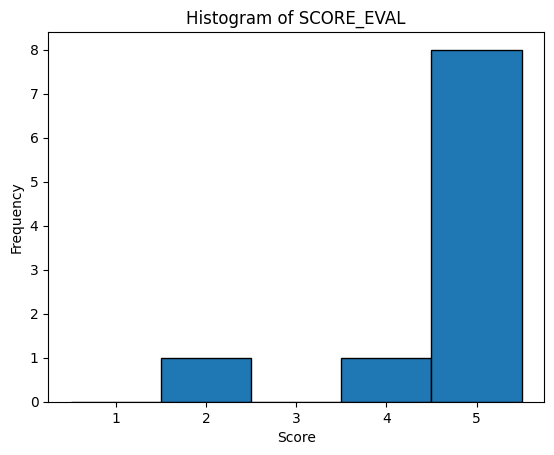

In [42]:
import matplotlib.pyplot as plt

# Plotting histogram
plt.hist(output['SCORE_EVAL'], bins=range(1, 7), edgecolor='black', align='left')  # bins from 1 to 5
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Histogram of SCORE_EVAL')
plt.xticks(range(1, 6))  # Setting x-ticks to show each score
plt.show()

In [43]:
scores = (output["SCORE_EVAL"] - 1) / 4
print (scores.mean())

0.9
